In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import geopandas as gpd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
dir_files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        dir_files.append(os.path.join(dirname, filename))
    
print(dir_files)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['/kaggle/input/nyc-building-energy-efficiency-ratings/geojson_lookup_rows.csv', '/kaggle/input/nyc-building-energy-efficiency-ratings/energy_disclosure_2021_rows.csv']


# 🧩 Initialize Data

In [2]:
energy_ratings = pd.read_csv(dir_files[1])
energy_features = pd.read_csv(dir_files[0])
energy_ratings.head()

,10_Digit_BBL,Street_Number,Street_Name,DOF_Gross_Square_Footage,Energy_Efficiency_Grade,Energy_Star_1-100_Score
0,1007610020,325,WEST 37 STREET,48843,A,100
1,1007610022,313,WEST 37 STREET,82354,C,62
2,1007610028,307,WEST 37 STREET,102824,B,79
3,1007610033,545,8 AVENUE,166874,A,86
4,1007610037,555,8 AVENUE,162260,A,100


In [3]:
energy_features.head()

,10_Digit_BBL,GeoBuilding,Latitude,Longitude
0,3017620041,"{""type"":""Feature"",""geometry"":{""type"":""MultiPol...",-73.955008,40.692556
1,1007017501,NaN,NaN,NaN
2,3021077502,NaN,NaN,NaN
3,1000130001,"{""type"":""Feature"",""geometry"":{""type"":""MultiPol...",-74.014611,40.704959
4,1000130005,"{""type"":""Feature"",""geometry"":{""type"":""MultiPol...",-74.014242,40.705379


In [4]:
print(energy_ratings.shape)
print(energy_features.shape)

(100, 6)
(100, 4)


In [5]:
energy_ratings.isnull().sum()

10_Digit_BBL                0
Street_Number               0
Street_Name                 0
DOF_Gross_Square_Footage    0
Energy_Efficiency_Grade     0
Energy_Star_1-100_Score     0
dtype: int64

In [6]:
energy_features.isnull().sum()

10_Digit_BBL     0
GeoBuilding     30
Latitude        30
Longitude       30
dtype: int64

In [7]:
energy_ratings.Street_Name.nunique()

30

In [8]:
energy_features["GeoBuilding"][0]

'{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-73.95504023749127,40.69278179995346],[-73.95495903439809,40.692791454119636],[-73.95494577341542,40.69272628510418],[-73.95488058792331,40.6924059263604],[-73.9548679225718,40.69234367973127],[-73.9549255822969,40.692336824210116],[-73.95505455555698,40.69232149028675],[-73.95506732713439,40.692382606793025],[-73.955134654852,40.6927047789995],[-73.95514807165077,40.69276898000251],[-73.95504023749127,40.69278179995346]]]]},"properties":{"name":null,"base_bbl":"3017620041","shape_area":"0.0","heightroof":"58.0","mpluto_bbl":"3017627505","cnstrct_yr":"2006","lststatype":"Constructed","feat_code":"2100","groundelev":"40","geomsource":"Other (Man","bin":"3396747","lstmoddate":"2017-08-10T00:00:00.000","doitt_id":"1098751","shape_len":"0.0"}}'

# 🧐 Exploratory Data Analysis

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [10]:
energy_ratings.columns

Index(['10_Digit_BBL', 'Street_Number', 'Street_Name',
       'DOF_Gross_Square_Footage', 'Energy_Efficiency_Grade',
       'Energy_Star_1-100_Score'],
      dtype='object')

<Axes: xlabel='Energy_Efficiency_Grade'>

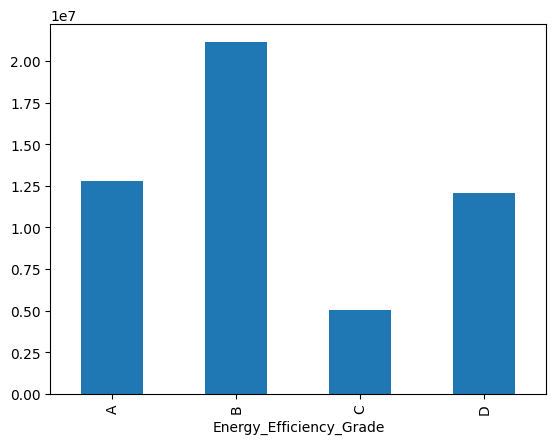

In [11]:
energy_ratings.groupby(["Energy_Efficiency_Grade"])["DOF_Gross_Square_Footage"].sum().plot(kind="bar")

1. In terms of total gross square footage, Grade B buildings ranks 1.
2. Grade C ranks lowest.
3. Grade A and B plays between 1.200k to 1.250k

In [12]:
plt.figure(figsize=(15,8))
energy_group_sum = energy_ratings.groupby(["Energy_Star_1-100_Score", "Energy_Efficiency_Grade"])["DOF_Gross_Square_Footage"].sum().reset_index()
energy_group_sum.head()

,Energy_Star_1-100_Score,Energy_Efficiency_Grade,DOF_Gross_Square_Footage
0,1,D,264668
1,3,D,91553
2,4,D,616831
3,11,D,283905
4,14,D,239121


<Figure size 1500x800 with 0 Axes>

<Axes: xlabel='Energy_Efficiency_Grade', ylabel='Energy_Star_1-100_Score'>

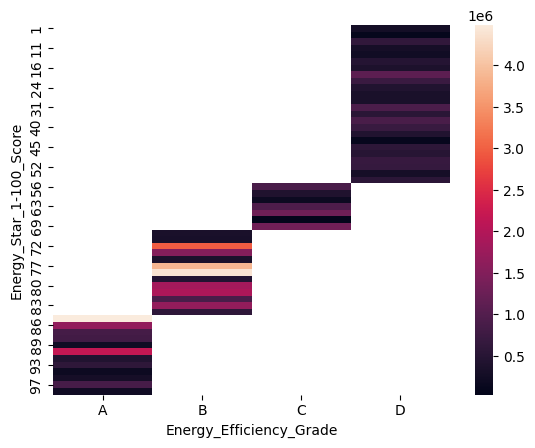

In [13]:
energy_rank_sum_matrix = energy_group_sum.pivot(
    index="Energy_Efficiency_Grade",
    columns="Energy_Star_1-100_Score",
    values="DOF_Gross_Square_Footage"
).T

sns.heatmap(energy_rank_sum_matrix)

In [14]:
plt.figure(figsize=(15,8))
energy_group_avg = energy_ratings.groupby(["Energy_Star_1-100_Score", "Energy_Efficiency_Grade"])["DOF_Gross_Square_Footage"].mean().reset_index()
energy_group_avg.head()

,Energy_Star_1-100_Score,Energy_Efficiency_Grade,DOF_Gross_Square_Footage
0,1,D,132334.0
1,3,D,91553.0
2,4,D,308415.5
3,11,D,283905.0
4,14,D,239121.0


<Figure size 1500x800 with 0 Axes>

<Axes: xlabel='Energy_Efficiency_Grade', ylabel='Energy_Star_1-100_Score'>

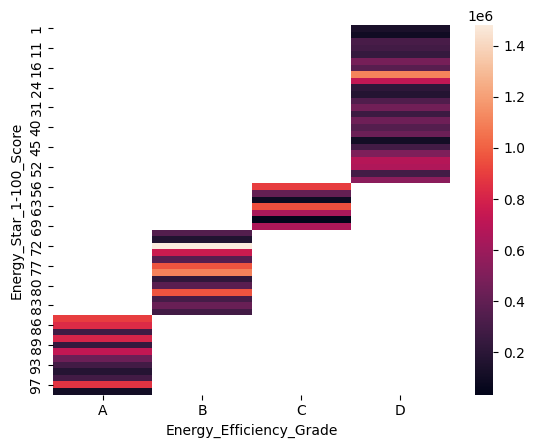

In [15]:
energy_rank_avg_matrix = energy_group_avg.pivot(
    index="Energy_Efficiency_Grade",
    columns="Energy_Star_1-100_Score",
    values="DOF_Gross_Square_Footage"
).T

sns.heatmap(energy_rank_avg_matrix)

In [16]:
energy_ratings.columns

Index(['10_Digit_BBL', 'Street_Number', 'Street_Name',
       'DOF_Gross_Square_Footage', 'Energy_Efficiency_Grade',
       'Energy_Star_1-100_Score'],
      dtype='object')

In [17]:
fig = px.box(energy_ratings,
            x="Energy_Efficiency_Grade",
            y="DOF_Gross_Square_Footage")
fig.update_layout(template="plotly_white",
                 yaxis_title="DOF_Gross_Square_Footage",
                 title="Distribution DOF-GSF per Energy Efficiency Grade")
fig.show()

In [18]:
def calculate_std_var(df, grade, feature):
    footage_filter = df[df[feature]==grade]
    std = footage_filter["DOF_Gross_Square_Footage"].std()
    var = footage_filter["DOF_Gross_Square_Footage"].var()
    return std, var

grades = ["A", "B", "C", "D"]
metrics_ = []
for grade in grades:
    metrics = calculate_std_var(energy_ratings, grade, "Energy_Efficiency_Grade")
    metrics_dict = {"grade": grade, "std_dev": metrics[0], "variance": metrics[1]}
    metrics_.append(metrics_dict)
metrics_df = pd.DataFrame(metrics_)
metrics_df

,grade,std_dev,variance
0,A,520167.947521,2.705747e+11
1,B,735753.784419,5.413336e+11
2,C,375776.225010,1.412078e+11
3,D,224129.091403,5.023385e+10


1. Buildings with Grade A have a `moderate range` of sizes with considerable variability in gross square footage.
2. Buildings with Grade B show the `highest variability` in sizes, indicating a diverse range of building sizes.
3. Buildings with Grade C have `less variability` in sizes compared to Grade A and B, but still a moderate range of sizes.
4. Buildings with Grade D have the `least variability` in sizes, indicating that these buildings are more uniform in gross square footage.


In [19]:
street_name_list = sorted(energy_ratings["Street_Name"].unique())
metrics_ = []
for streets in street_name_list:
    metrics = calculate_std_var(energy_ratings, streets, "Street_Name")
    metrics_dict = {"Street_Name": streets, "std_dev": metrics[0], "variance": metrics[1]}
    metrics_.append(metrics_dict)
metrics_df = pd.DataFrame(metrics_)

Text(0.5, 1.0, 'Std. Deviation (Gross Square Footage) per Street')

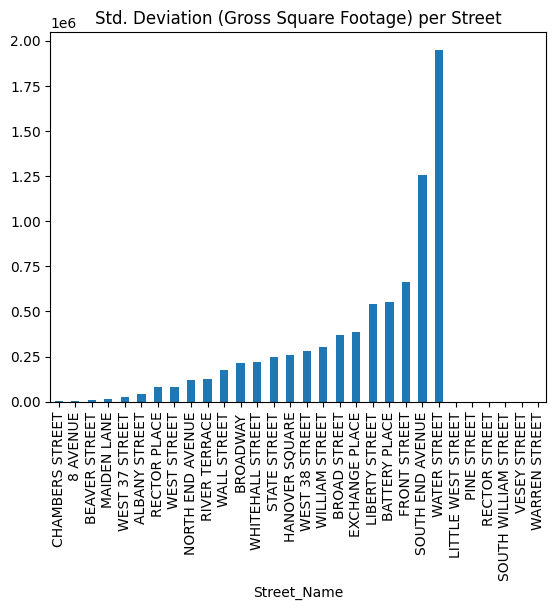

In [20]:
metrics_df.sort_values(by="std_dev").set_index("Street_Name")["std_dev"].plot(kind="bar")
plt.title("Std. Deviation (Gross Square Footage) per Street")

Text(0.5, 1.0, 'Variance (Gross Square Footage) per Street')

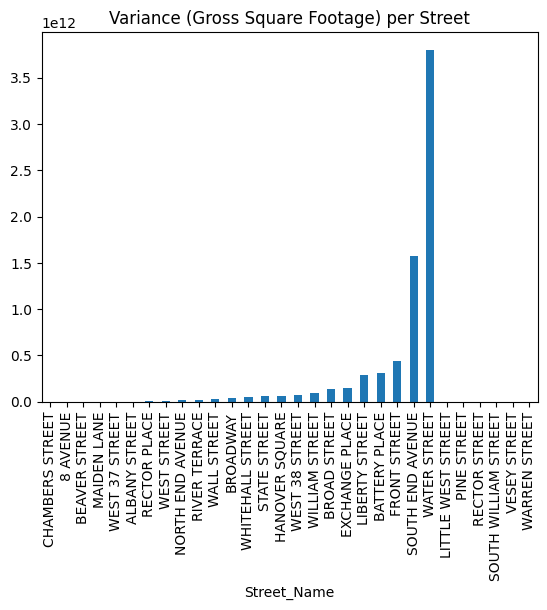

In [21]:
metrics_df.sort_values(by="variance").set_index("Street_Name")["variance"].plot(kind="bar")
plt.title("Variance (Gross Square Footage) per Street")

# 🗺️Spatial Analysis